In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import src.utils as utils
import scipy.stats as stats


In [92]:
# Read simulation outputs

# Online Communication Network
list_pre_results_class_com = pickle.load(open('../output/simulation/communication/list_pre_results_class.obj', 'rb'))
list_results_class_com = pickle.load(open('../output/simulation/communication/list_results_class_0.17.obj', 'rb'))
list_results_class_com005 = pickle.load(open('../output/simulation/communication/list_results_class_0.05.obj', 'rb'))
list_results_class_com010 = pickle.load(open('../output/simulation/communication/list_results_class_0.1.obj', 'rb'))
list_results_class_com015 = pickle.load(open('../output/simulation/communication/list_results_class_0.15.obj', 'rb'))
list_results_class_com020 = pickle.load(open('../output/simulation/communication/list_results_class_0.2.obj', 'rb'))

# Peer Nomination Network
list_pre_results_class_nom = pickle.load(open('../output/simulation/nomination/list_pre_results_class.obj', 'rb'))
list_results_class_nom = pickle.load(open('../output/simulation/nomination/list_results_class_0.17.obj', 'rb'))
list_results_class_nom005 = pickle.load(open('../output/simulation/nomination/list_results_class_0.05.obj', 'rb'))
list_results_class_nom010 = pickle.load(open('../output/simulation/nomination/list_results_class_0.1.obj', 'rb'))
list_results_class_nom015 = pickle.load(open('../output/simulation/nomination/list_results_class_0.15.obj', 'rb'))
list_results_class_nom020 = pickle.load(open('../output/simulation/nomination/list_results_class_0.2.obj', 'rb'))

# Peer Nomination Network (Social Facilitation
list_pre_results_class_nom_soc = pickle.load(open('../output/simulation/nomination_social/list_pre_results_class.obj', 'rb'))
list_results_class_nom_soc = pickle.load(open('../output/simulation/nomination_social/list_results_class_0.17.obj', 'rb'))
list_results_class_nom_soc005 = pickle.load(open('../output/simulation/nomination_social/list_results_class_0.05.obj', 'rb'))
list_results_class_nom_soc010 = pickle.load(open('../output/simulation/nomination_social/list_results_class_0.1.obj', 'rb'))
list_results_class_nom_soc015 = pickle.load(open('../output/simulation/nomination_social/list_results_class_0.15.obj', 'rb'))
list_results_class_nom_soc020 = pickle.load(open('../output/simulation/nomination_social/list_results_class_0.2.obj', 'rb'))

# Read input variables
input_args = utils.load_input_args('../input/simulation.json')

## Postprocessing Simulation Output

### Functions


In [93]:
# calculate mean per run
def calc_mean_by_run(file):
    by_run_noint = []
    by_run_indegree = []
    by_run_betweenness = []
    by_run_closeness = []
    for run in range(len(file)):
        by_run_noint.append(pd.DataFrame(file[run]['nointervention']).mean(axis=1))
        by_run_indegree.append(pd.DataFrame(file[run]['indegree']).mean(axis=1))
        by_run_betweenness.append(pd.DataFrame(file[run]['betweenness']).mean(axis=1))
        by_run_closeness.append(pd.DataFrame(file[run]['closeness']).mean(axis=1))

    out_noint = pd.concat(by_run_noint, axis =1)
    out_indegree = pd.concat(by_run_indegree, axis =1)
    out_betweenness = pd.concat(by_run_betweenness, axis =1)
    out_closeness = pd.concat(by_run_closeness, axis =1)

    return out_noint, out_indegree, out_betweenness, out_closeness

# calculate overall mean, median & prediction interval
def calc_mean_by_intervention(file_by_run, file_noint):
    out = pd.DataFrame()

    out['mean'] = file_by_run.mean(axis=1)
    out['median'] = file_by_run.median(axis=1)
    out['lower'] = file_by_run.quantile(q=0.025, axis=1)
    out['upper'] = file_by_run.quantile(q=0.975, axis=1)

    out_sr = file_by_run.div(file_by_run.iloc[0])
    out['mean_sr'] = (out_sr.mean(axis=1) -1) *100
    out['median_sr'] = (out_sr.median(axis=1) -1) *100
    out['lower_sr'] = (out_sr.quantile(q=0.025, axis=1) -1) *100
    out['upper_sr'] = (out_sr.quantile(q=0.975, axis=1) -1) *100

    out_ef = file_by_run - file_noint
    out['mean_ef'] = (out_ef.mean(axis=1))
    out['median_ef'] = (out_ef.median(axis=1))
    out['lower_ef'] = (out_ef.quantile(q=0.025, axis=1))
    out['upper_ef'] = (out_ef.quantile(q=0.975, axis=1))

    out_ef2 = file_by_run - file_by_run.iloc[0]
    out['mean_ef2'] = (out_ef2.mean(axis=1))
    out['median_ef2'] = (out_ef2.median(axis=1))
    out['lower_ef2'] = (out_ef2.quantile(q=0.025, axis=1))
    out['upper_ef2'] = (out_ef2.quantile(q=0.975, axis=1))
    return out

# variation between runs by effectiveness by strategy
def calc_variation_by_strategy(file1, file2, file3, day=200):
    out_var = {'In-degree': (file1.iloc[day] / file1.iloc[0] - 1) * 100,
               'Betweenness': (file2.iloc[day] / file2.iloc[0] - 1) * 100,
               'Closeness': (file3.iloc[day] / file3.iloc[0] - 1) * 100}

    return out_var

def calc_variation_by_strategy_steps(file1, file2, file3, file4, day=200):
    out_var = {'In-degree': (file1.iloc[day] / file4.iloc[day] ),
               'Betweenness': (file2.iloc[day] /file4.iloc[day]),
               'Closeness': (file3.iloc[day] /file4.iloc[day])}

    return out_var


# variation between runs by effectiveness
def calc_variation_by_effect(file, file005, file010, file020, day=200):
    out_var = {'Ref. 17%': (file.iloc[day] / file.iloc[0] - 1) * 100,
               '5%': (file005.iloc[day] / file005.iloc[0] - 1) * 100,
               '10%': (file010.iloc[day] / file010.iloc[0] - 1) * 100,
               '20%': (file020.iloc[day] / file020.iloc[0] - 1) * 100 }

    return out_var

# calculate mean per class
def calc_mean_by_class(file, day = 200):
    by_class_noint = []
    by_class_indegree = []
    by_class_betweenness = []
    by_class_closeness = []

    for class_id in input_args['classes']:
        temp_by_run_noint = []
        temp_by_run_indegree = []
        temp_by_run_betweenness = []
        temp_by_run_closeness = []
        for run in range(len(file)):
            temp_by_run_noint.append(pd.DataFrame(file[run]['nointervention'][str(class_id)]))
            temp_by_run_indegree.append(pd.DataFrame(file[run]['indegree'][str(class_id)]))
            temp_by_run_betweenness.append(pd.DataFrame(file[run]['betweenness'][str(class_id)]))
            temp_by_run_closeness.append(pd.DataFrame(file[run]['closeness'][str(class_id)]))

        # concat to dataframe
        temp_noint = pd.concat(temp_by_run_noint, axis =1)
        temp_indegree = pd.concat(temp_by_run_indegree, axis =1)
        temp_betweenness = pd.concat(temp_by_run_betweenness, axis =1)
        temp_closeness = pd.concat(temp_by_run_closeness, axis =1)

        # select at day
        by_class_noint.append((temp_noint.iloc[day]/temp_noint.iloc[0] -1) * 100)
        by_class_indegree.append((temp_indegree.iloc[day]/temp_indegree.iloc[0] -1) * 100)
        by_class_betweenness.append((temp_betweenness.iloc[day]/temp_betweenness.iloc[0] -1) * 100)
        by_class_closeness.append((temp_closeness.iloc[day]/temp_closeness.iloc[0] -1) * 100)

    # Dataframe cols=class, rows= results of day 700 per run
    class_noint = pd.concat(by_class_noint, axis=1)
    class_indegree = pd.concat(by_class_indegree, axis=1)
    class_betweenness = pd.concat(by_class_betweenness, axis=1)
    class_closeness = pd.concat(by_class_closeness, axis=1)

    return class_noint, class_indegree, class_betweenness, class_closeness

### Step 1: Calculate mean per run

In [94]:
# Online Communication Network
out_noint_com, out_indegree_com, out_betweenness_com, out_closeness_com = calc_mean_by_run(list_results_class_com)
out_noint_com005, out_indegree_com005, out_betweenness_com005, out_closeness_com005 = calc_mean_by_run(list_results_class_com005)
out_noint_com010, out_indegree_com010, out_betweenness_com010, out_closeness_com010 = calc_mean_by_run(list_results_class_com010)
out_noint_com015, out_indegree_com015, out_betweenness_com015, out_closeness_com015 = calc_mean_by_run(list_results_class_com015)
out_noint_com020, out_indegree_com020, out_betweenness_com020, out_closeness_com020 = calc_mean_by_run(list_results_class_com020)

# Peer Nomination Network (Social Facilitation)
out_noint_nom_soc, out_indegree_nom_soc, out_betweenness_nom_soc, out_closeness_nom_soc = calc_mean_by_run(list_results_class_nom_soc)
out_noint_nom_soc005, out_indegree_nom_soc005, out_betweenness_nom_soc005, out_closeness_nom_soc005 = calc_mean_by_run(list_results_class_nom_soc005)
out_noint_nom_soc010, out_indegree_nom_soc010, out_betweenness_nom_soc010, out_closeness_nom_soc010 = calc_mean_by_run(list_results_class_nom_soc010)
out_noint_nom_soc015, out_indegree_nom_soc015, out_betweenness_nom_soc015, out_closeness_nom_soc015 = calc_mean_by_run(list_results_class_nom_soc015)
out_noint_nom_soc020, out_indegree_nom_soc020, out_betweenness_nom_soc020, out_closeness_nom_soc020 = calc_mean_by_run(list_results_class_nom_soc020)

### Step 2: calculate mean, median, 95%CI over 100 runs

In [95]:
################################
# Online Communication Network #
################################

out_noint_com_sr = calc_mean_by_intervention(out_noint_com, out_noint_com)
out_indegree_com_sr = calc_mean_by_intervention(out_indegree_com, out_noint_com)
out_betweenness_com_sr = calc_mean_by_intervention(out_betweenness_com, out_noint_com)
out_closeness_com_sr = calc_mean_by_intervention(out_closeness_com, out_noint_com)

out_noint_com005_sr = calc_mean_by_intervention(out_noint_com005, out_noint_com005)
out_indegree_com005_sr = calc_mean_by_intervention(out_indegree_com005, out_noint_com005)
out_betweenness_com005_sr = calc_mean_by_intervention(out_betweenness_com005, out_noint_com005)
out_closeness_com005_sr = calc_mean_by_intervention(out_closeness_com005, out_noint_com005)

out_noint_com010_sr = calc_mean_by_intervention(out_noint_com010, out_noint_com010)
out_indegree_com010_sr = calc_mean_by_intervention(out_indegree_com010, out_noint_com010)
out_betweenness_com010_sr = calc_mean_by_intervention(out_betweenness_com010, out_noint_com010)
out_closeness_com010_sr = calc_mean_by_intervention(out_closeness_com010, out_noint_com010)

out_noint_com015_sr = calc_mean_by_intervention(out_noint_com015, out_noint_com015)
out_indegree_com015_sr = calc_mean_by_intervention(out_indegree_com015, out_noint_com015)
out_betweenness_com015_sr = calc_mean_by_intervention(out_betweenness_com015, out_noint_com015)
out_closeness_com015_sr = calc_mean_by_intervention(out_closeness_com015, out_noint_com015)

out_noint_com020_sr = calc_mean_by_intervention(out_noint_com020, out_noint_com020)
out_indegree_com020_sr = calc_mean_by_intervention(out_indegree_com020, out_noint_com020)
out_betweenness_com020_sr = calc_mean_by_intervention(out_betweenness_com020, out_noint_com020)
out_closeness_com020_sr = calc_mean_by_intervention(out_closeness_com020, out_noint_com020)

#################################################
# Peer Nomination Network (Social Facilitation) #
#################################################

out_noint_nom_soc_sr = calc_mean_by_intervention(out_noint_nom_soc, out_noint_nom_soc)
out_indegree_nom_soc_sr = calc_mean_by_intervention(out_indegree_nom_soc, out_noint_nom_soc)
out_betweenness_nom_soc_sr = calc_mean_by_intervention(out_betweenness_nom_soc, out_noint_nom_soc)
out_closeness_nom_soc_sr = calc_mean_by_intervention(out_closeness_nom_soc, out_noint_nom_soc)

out_noint_nom_soc005_sr = calc_mean_by_intervention(out_noint_nom_soc005, out_noint_nom_soc005)
out_indegree_nom_soc005_sr = calc_mean_by_intervention(out_indegree_nom_soc005, out_noint_nom_soc005)
out_betweenness_nom_soc005_sr = calc_mean_by_intervention(out_betweenness_nom_soc005, out_noint_nom_soc005)
out_closeness_nom_soc005_sr = calc_mean_by_intervention(out_closeness_nom_soc005, out_noint_nom_soc005)

out_noint_nom_soc010_sr = calc_mean_by_intervention(out_noint_nom_soc010, out_noint_nom_soc010)
out_indegree_nom_soc010_sr = calc_mean_by_intervention(out_indegree_nom_soc010, out_noint_nom_soc010)
out_betweenness_nom_soc010_sr = calc_mean_by_intervention(out_betweenness_nom_soc010, out_noint_nom_soc010)
out_closeness_nom_soc010_sr = calc_mean_by_intervention(out_closeness_nom_soc010, out_noint_nom_soc010)

out_noint_nom_soc015_sr = calc_mean_by_intervention(out_noint_nom_soc015, out_noint_nom_soc015)
out_indegree_nom_soc015_sr = calc_mean_by_intervention(out_indegree_nom_soc015, out_noint_nom_soc015)
out_betweenness_nom_soc015_sr = calc_mean_by_intervention(out_betweenness_nom_soc015, out_noint_nom_soc015)
out_closeness_nom_soc015_sr = calc_mean_by_intervention(out_closeness_nom_soc015, out_noint_nom_soc015)

out_noint_nom_soc020_sr = calc_mean_by_intervention(out_noint_nom_soc020, out_noint_nom_soc020)
out_indegree_nom_soc020_sr = calc_mean_by_intervention(out_indegree_nom_soc020, out_noint_nom_soc020)
out_betweenness_nom_soc020_sr = calc_mean_by_intervention(out_betweenness_nom_soc020, out_noint_nom_soc020)
out_closeness_nom_soc020_sr = calc_mean_by_intervention(out_closeness_nom_soc020, out_noint_nom_soc020)


### Step 3 calculate variation between runs

In [96]:
# for boxplot of variation at day 200

# variation by strategy (%)
com_var = calc_variation_by_strategy(out_indegree_com, out_betweenness_com, out_closeness_com,day=200)
nom_soc_var = calc_variation_by_strategy(out_indegree_nom_soc, out_betweenness_nom_soc, out_closeness_nom_soc, day=200)


# variation by strategy (steps/10,000)
com_var_steps = calc_variation_by_strategy_steps(out_indegree_com, out_betweenness_com,
                                                 out_closeness_com, out_noint_com, day=200)
nom_soc_var_steps = calc_variation_by_strategy_steps(out_indegree_nom_soc, out_betweenness_nom_soc,
                                                     out_closeness_nom_soc, out_noint_nom_soc, day=200)


# variation by effectiveness
com_indegree_var_by_effect = calc_variation_by_effect(out_indegree_com, out_indegree_com005, out_indegree_com010, out_indegree_com020)
nom_soc_indegree_var_by_effect = calc_variation_by_effect(out_indegree_nom_soc, out_indegree_nom_soc005, out_indegree_nom_soc010, out_indegree_nom_soc020)

com_betweenness_var_by_effect = calc_variation_by_effect(out_betweenness_com, out_betweenness_com005, out_betweenness_com010, out_betweenness_com020)
nom_soc_betweenness_var_by_effect = calc_variation_by_effect(out_betweenness_nom_soc, out_betweenness_nom_soc005, out_betweenness_nom_soc010, out_betweenness_nom_soc020)

com_closeness_var_by_effect = calc_variation_by_effect(out_closeness_com, out_closeness_com005, out_closeness_com010, out_closeness_com020)
nom_soc_closeness_var_by_effect = calc_variation_by_effect(out_closeness_nom_soc, out_closeness_nom_soc005, out_closeness_nom_soc010, out_closeness_nom_soc020)


In [56]:
# equal variances
print(stats.levene(com_var['In-degree'],com_var['Betweenness'], com_var['Closeness']))
print(stats.levene(nom_soc_var['In-degree'],nom_soc_var['Betweenness'], nom_soc_var['Closeness']))
print(stats.levene(com_var['In-degree'],nom_soc_var['In-degree']))
print(stats.levene(com_var['Betweenness'],nom_soc_var['Betweenness']))
print(stats.levene(com_var['Closeness'],nom_soc_var['Closeness']))
print()
print(stats.levene(com_var_steps['In-degree'],com_var_steps['Betweenness'], com_var_steps['Closeness']))
print(stats.levene(nom_soc_var_steps['In-degree'],nom_soc_var_steps['Betweenness'], nom_soc_var_steps['Closeness']))
print(stats.levene(com_var_steps['In-degree'],nom_soc_var_steps['In-degree']))
print(stats.levene(com_var_steps['Betweenness'],nom_soc_var_steps['Betweenness']))
print(stats.levene(com_var_steps['Closeness'],nom_soc_var_steps['Closeness']))



# normality
print(stats.shapiro(com_var['In-degree']))
print(stats.shapiro(nom_soc_var['In-degree']))
print(stats.shapiro(com_var['Betweenness']))
print(stats.shapiro(nom_soc_var['Betweenness']))
print(stats.shapiro(com_var['Closeness']))
print(stats.shapiro(nom_soc_var['Closeness']))
print()
# normality
print(stats.shapiro(com_var_steps['In-degree']))
print(stats.shapiro(nom_soc_var_steps['In-degree']))
print(stats.shapiro(com_var_steps['Betweenness']))
print()
print(stats.shapiro(nom_soc_var_steps['Betweenness']))
print(stats.shapiro(com_var_steps['Closeness']))
print(stats.shapiro(nom_soc_var_steps['Closeness']))


LeveneResult(statistic=0.5902970958187627, pvalue=0.5548114453038385)
LeveneResult(statistic=0.13576882887271668, pvalue=0.8730985856240212)
LeveneResult(statistic=0.4105085890294114, pvalue=0.5224523095962835)
LeveneResult(statistic=0.25690660095623036, pvalue=0.6128173669667865)
LeveneResult(statistic=0.0778087526811494, pvalue=0.7805803068804023)

LeveneResult(statistic=0.867089148181501, pvalue=0.42123369704999347)
LeveneResult(statistic=0.14968600592742948, pvalue=0.8610431877339332)
LeveneResult(statistic=0.2734522096097891, pvalue=0.6016100157782938)
LeveneResult(statistic=0.4147221449785835, pvalue=0.5203276832450566)
LeveneResult(statistic=0.04331826165659878, pvalue=0.8353410865521973)
ShapiroResult(statistic=0.6227211952209473, pvalue=1.187074069819655e-14)
ShapiroResult(statistic=0.5640366077423096, pvalue=9.381029651277673e-16)
ShapiroResult(statistic=0.40016138553619385, pvalue=2.4184635256876268e-18)
ShapiroResult(statistic=0.4412854313850403, pvalue=9.51222135669642e-18

In [57]:

#print(stats.mannwhitneyu(com_var['In-degree'], com_var['Betweenness'],com_var['Closeness']))
print(stats.mannwhitneyu(com_var['In-degree'], com_var['Betweenness']))
print(stats.mannwhitneyu(com_var['In-degree'], com_var['Closeness']))
print(stats.mannwhitneyu(com_var['Betweenness'],com_var['Closeness']))

#print(stats.mannwhitneyu(nom_soc_var['In-degree'], nom_soc_var['Betweenness'],nom_soc_var['Closeness']))
print(stats.mannwhitneyu(nom_soc_var['In-degree'], nom_soc_var['Betweenness']))
print(stats.mannwhitneyu(nom_soc_var['In-degree'], nom_soc_var['Closeness']))
print(stats.mannwhitneyu(nom_soc_var['Betweenness'],nom_soc_var['Closeness']))


print(stats.mannwhitneyu(com_var['In-degree'], nom_soc_var['In-degree']))
print(stats.mannwhitneyu(com_var['Betweenness'], nom_soc_var['Betweenness']))
print(stats.mannwhitneyu(com_var['Closeness'], nom_soc_var['Closeness']))

print(stats.mannwhitneyu(com_var_steps['In-degree'], nom_soc_var_steps['In-degree']))
print(stats.mannwhitneyu(com_var_steps['Betweenness'], nom_soc_var_steps['Betweenness']))
print(stats.mannwhitneyu(com_var_steps['Closeness'], nom_soc_var_steps['Closeness']))


MannwhitneyuResult(statistic=5924.0, pvalue=0.02404123475249789)
MannwhitneyuResult(statistic=4601.0, pvalue=0.3302102498039833)
MannwhitneyuResult(statistic=3505.0, pvalue=0.0002605662243684299)
MannwhitneyuResult(statistic=7425.0, pvalue=3.142104193351925e-09)
MannwhitneyuResult(statistic=6069.0, pvalue=0.00903409987925682)
MannwhitneyuResult(statistic=3472.0, pvalue=0.00018975702278925598)
MannwhitneyuResult(statistic=6296.0, pvalue=0.0015486440137675755)
MannwhitneyuResult(statistic=8344.0, pvalue=3.097452872144294e-16)
MannwhitneyuResult(statistic=7752.0, pvalue=1.7803950173568744e-11)
MannwhitneyuResult(statistic=6348.0, pvalue=0.0009931271959862677)
MannwhitneyuResult(statistic=8236.0, pvalue=2.6667877426133914e-15)
MannwhitneyuResult(statistic=7870.0, pvalue=2.3610638823053727e-12)


In [70]:
print(out_indegree_com_sr['median_sr'].iloc[199])
print(out_betweenness_com_sr['median_sr'].iloc[199])
print(out_closeness_com_sr['median_sr'].iloc[199])
print(out_indegree_nom_soc_sr['median_sr'].iloc[199])
print(out_betweenness_nom_soc_sr['median_sr'].iloc[199])
print(out_closeness_nom_soc_sr['median_sr'].iloc[199])
print()
print(out_indegree_com_sr['median_ef'].iloc[199]*10000)
print(out_betweenness_com_sr['median_ef'].iloc[199]*10000)
print(out_closeness_com_sr['median_ef'].iloc[199]*10000)
print(out_indegree_nom_soc_sr['median_ef'].iloc[199]*10000)
print(out_betweenness_nom_soc_sr['median_ef'].iloc[199]*10000)
print(out_closeness_nom_soc_sr['median_ef'].iloc[199]*10000)
print()
print(out_indegree_com_sr['median_ef2'].iloc[199]*10000)
print(out_betweenness_com_sr['median_ef2'].iloc[199]*10000)
print(out_closeness_com_sr['median_ef2'].iloc[199]*10000)
print(out_indegree_nom_soc_sr['median_ef2'].iloc[199]*10000)
print(out_betweenness_nom_soc_sr['median_ef2'].iloc[199]*10000)
print(out_closeness_nom_soc_sr['median_ef2'].iloc[199]*10000)

5.728538150568063
5.579233043534826
5.810261534577643
5.488009110645775
5.037840784332603
5.3033807528003685

837.825669262498
829.3904012511233
851.9711329590484
815.6183926811822
775.031770828753
792.3567260565595

581.1410559563645
568.561881307037
594.2193849445642
561.39677333995
512.4412518530041
536.6665683410521


### Step 4 calculate variation between classes

In [97]:
# Online Communication Network
class_noint_com, class_indegree_com, class_betweenness_com, class_closeness_com = calc_mean_by_class(list_results_class_com)

# Peer Nomination Network
class_noint_nom, class_indegree_nom, class_betweenness_nom, class_closeness_nom = calc_mean_by_class(list_results_class_nom)

# Peer Nomination Network (Social Facilitation)
class_noint_nom_soc, class_indegree_nom_soc, class_betweenness_nom_soc, class_closeness_nom_soc = calc_mean_by_class(list_results_class_nom_soc)



# Plots of Simulation Output

## 1. Change in number of steps/10,000

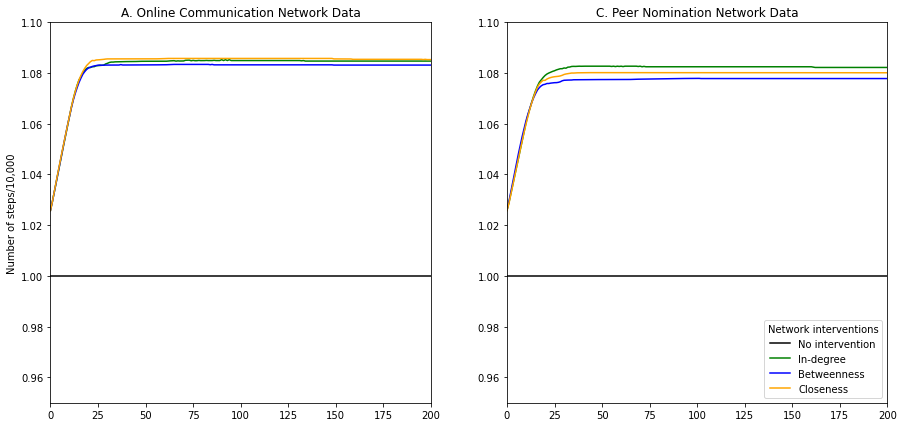

In [39]:
# Plots
ticks = np.arange(1.40, 1.60, 0.01)
x = np.arange(0,730,1)
ylim = [0.95, 1.1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

ax1.set_title('A. Online Communication Network Data')
ax1.set_ylim(ylim)
ax1.set_xlim([0,200])
ax1.set_ylabel('Number of steps/10,000')
ax1.plot(x, out_noint_com_sr['median_ef'], color='black')
ax1.plot(x, out_indegree_com_sr['median_ef'], color='green')
ax1.plot(x, out_betweenness_com_sr['median_ef'], color='blue')
ax1.plot(x, out_closeness_com_sr['median_ef'], color='orange')

ax2.set_title('C. Peer Nomination Network Data')
ax2.set_ylim(ylim)
ax2.set_xlim([0,200])
ax2.plot(x, out_noint_nom_soc_sr['median_ef'], color='black')
ax2.plot(x, out_indegree_nom_soc_sr['median_ef'], color='green')
ax2.plot(x, out_betweenness_nom_soc_sr['median_ef'], color='blue')
ax2.plot(x, out_closeness_nom_soc_sr['median_ef'], color='orange')

ax2.legend(['No intervention', 'In-degree', 'Betweenness', 'Closeness'], loc='lower right', title="Network interventions")


In [10]:
fig.savefig('../output/plots/fig_pal_trend_revised.eps', bbox_inches='tight', format='eps', dpi=1000)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## 2. Impact on PAL: success rate (used in paper)

[Text(1, 0, 'In-degree'), Text(2, 0, 'Betweenness'), Text(3, 0, 'Closeness')]

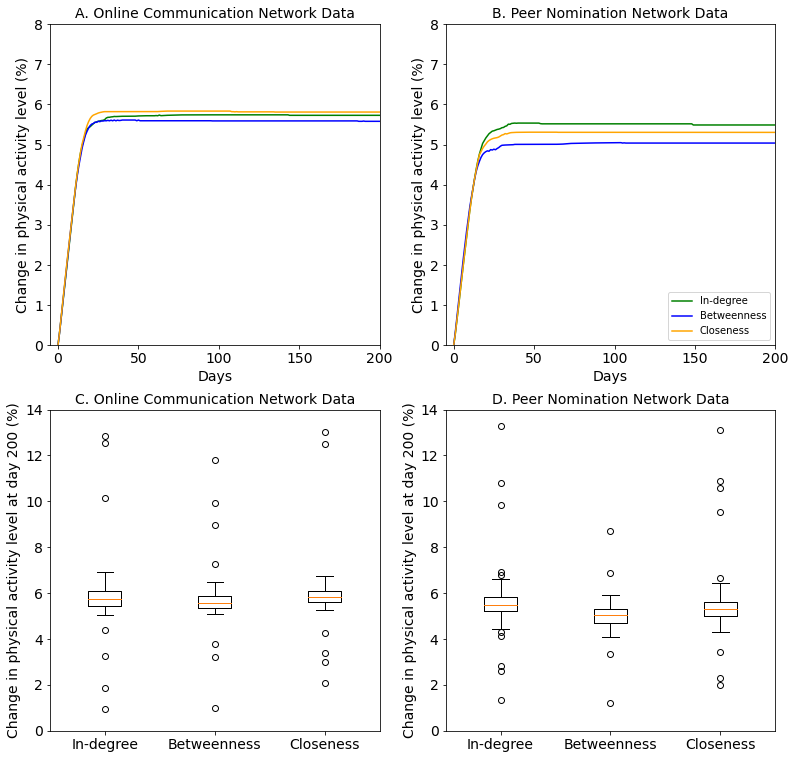

In [103]:
# Plot (without confidence intervals): used in paper
ticks = np.arange(1.40, 1.60, 0.01)
x = np.arange(0, 730, 1)

fig, axs = plt.subplots(2, 2, figsize=(13, 13))

axs[0,0].set_title('A. Online Communication Network Data', fontsize=14)
axs[0,0].set_xlabel('Days', fontsize=14)
axs[0,0].set_ylabel('Change in physical activity level (%)', fontsize=14)
axs[0,0].tick_params(axis='both', which='both', labelsize=14)
axs[0,0].set_ylim([0, 8])
axs[0,0].set_xlim([-5,200])
axs[0,0].plot(x, out_indegree_com_sr['median_sr'], color='green')
axs[0,0].plot(x, out_betweenness_com_sr['median_sr'], color='blue')
axs[0,0].plot(x, out_closeness_com_sr['median_sr'], color='orange')

axs[0,1].set_title('B. Peer Nomination Network Data', fontsize=14)
axs[0,1].set_xlabel('Days', fontsize=14)
axs[0,1].set_ylabel('Change in physical activity level (%)', fontsize=14)
axs[0,1].tick_params(axis='both', which='both', labelsize=14)
axs[0,1].set_ylim([0, 8])
axs[0,1].set_xlim([-5,200])
axs[0,1].plot(x, out_indegree_nom_soc_sr['median_sr'], color='green')
axs[0,1].plot(x, out_betweenness_nom_soc_sr['median_sr'], color='blue')
axs[0,1].plot(x, out_closeness_nom_soc_sr['median_sr'], color='orange')

axs[0,1].legend(['In-degree', 'Betweenness', 'Closeness'], loc='lower right', title="")

axs[1,0].set_title('C. Online Communication Network Data', fontsize=14)
axs[1,0].set_ylabel('Change in physical activity level at day 200 (%)', fontsize=14)
axs[1,0].tick_params(axis='both', which='both', labelsize=14)
axs[1,0].set_ylim([0, 14])
axs[1,0].boxplot(com_var.values())
axs[1,0].set_xticklabels(com_var.keys())

axs[1,1].set_title('D. Peer Nomination Network Data', fontsize=14)
axs[1,1].set_ylabel('Change in physical activity level at day 200 (%)', fontsize=14)
axs[1,1].tick_params(axis='both', which='both', labelsize=14)
axs[1,1].set_ylim([0, 14])
axs[1,1].boxplot(nom_soc_var.values())
axs[1,1].set_xticklabels(nom_soc_var.keys())


In [104]:
fig.savefig('../output/plots/fig_impact_revised.png', bbox_inches='tight', format='png', dpi=1000)

## 3. Variation in effect

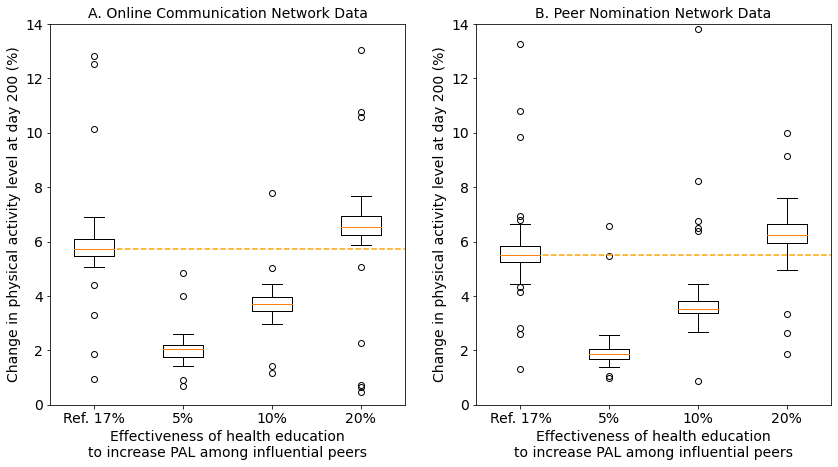

In [107]:
# Plot (without confidence intervals): used in paper
ticks = np.arange(1.40, 1.60, 0.01)
x = np.arange(0, 730, 1)

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].set_title('A. Online Communication Network Data', fontsize=14)
axs[0].set_ylabel('Change in physical activity level at day 200 (%)', fontsize=14)
axs[0].set_xlabel('Effectiveness of health education\nto increase PAL among influential peers', fontsize=14)
axs[0].tick_params(axis='both', which='both', labelsize=14)
axs[0].set_ylim([0, 14])
axs[0].boxplot(com_indegree_var_by_effect.values())
axs[0].set_xticklabels(com_indegree_var_by_effect.keys())
axs[0].hlines(pd.DataFrame(com_indegree_var_by_effect)['Ref. 17%'].median(), xmin=1.25, xmax=4.5, color='orange', linestyles='--')

axs[1].set_title('B. Peer Nomination Network Data', fontsize=14)
axs[1].set_ylabel('Change in physical activity level at day 200 (%)', fontsize=14)
axs[1].set_xlabel('Effectiveness of health education\nto increase PAL among influential peers', fontsize=14)
axs[1].tick_params(axis='both', which='both', labelsize=14)
axs[1].set_ylim([0, 14])
axs[1].boxplot(nom_soc_indegree_var_by_effect.values())
axs[1].set_xticklabels(nom_soc_indegree_var_by_effect.keys())
axs[1].hlines(pd.DataFrame(nom_soc_indegree_var_by_effect)['Ref. 17%'].median(), xmin=1.25, xmax=4.5, color='orange', linestyles='--')


In [109]:
fig.savefig('../output/plots/fig_effectvariation_revised.png', bbox_inches='tight', format='png', dpi=1000)

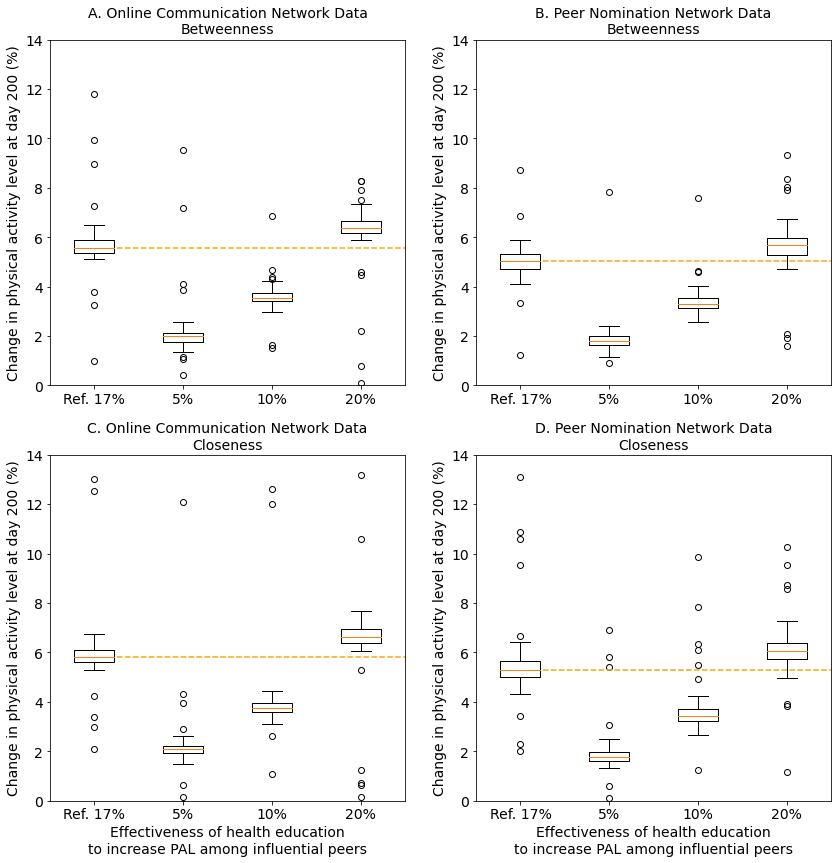

In [110]:
# Plot (without confidence intervals): used in paper
ticks = np.arange(1.40, 1.60, 0.01)
x = np.arange(0, 730, 1)

fig, axs = plt.subplots(2, 2, figsize=(14, 14))

axs[0,0].set_title('A. Online Communication Network Data\nBetweenness', fontsize=14)
axs[0,0].set_ylabel('Change in physical activity level at day 200 (%)', fontsize=14)
axs[0,0].tick_params(axis='both', which='both', labelsize=14)
axs[0,0].set_ylim([0, 14])
axs[0,0].boxplot(com_betweenness_var_by_effect.values())
axs[0,0].set_xticklabels(com_betweenness_var_by_effect.keys())
axs[0,0].hlines(pd.DataFrame(com_betweenness_var_by_effect)['Ref. 17%'].median(), xmin=1.25, xmax=4.5, color='orange', linestyles='--')

axs[0,1].set_title('B. Peer Nomination Network Data\nBetweenness', fontsize=14)
axs[0,1].set_ylabel('Change in physical activity level at day 200 (%)', fontsize=14)
axs[0,1].tick_params(axis='both', which='both', labelsize=14)
axs[0,1].set_ylim([0, 14])
axs[0,1].boxplot(nom_soc_betweenness_var_by_effect.values())
axs[0,1].set_xticklabels(nom_soc_betweenness_var_by_effect.keys())
axs[0,1].hlines(pd.DataFrame(nom_soc_betweenness_var_by_effect)['Ref. 17%'].median(), xmin=1.25, xmax=4.5, color='orange', linestyles='--')

axs[1,0].set_title('C. Online Communication Network Data\nCloseness', fontsize=14)
axs[1,0].set_ylabel('Change in physical activity level at day 200 (%)', fontsize=14)
axs[1,0].set_xlabel('Effectiveness of health education\nto increase PAL among influential peers', fontsize=14)
axs[1,0].tick_params(axis='both', which='both', labelsize=14)
axs[1,0].set_ylim([0, 14])
axs[1,0].boxplot(com_closeness_var_by_effect.values())
axs[1,0].set_xticklabels(com_closeness_var_by_effect.keys())
axs[1,0].hlines(pd.DataFrame(com_closeness_var_by_effect)['Ref. 17%'].median(), xmin=1.25, xmax=4.5, color='orange', linestyles='--')

axs[1,1].set_title('D. Peer Nomination Network Data\nCloseness', fontsize=14)
axs[1,1].set_ylabel('Change in physical activity level at day 200 (%)', fontsize=14)
axs[1,1].set_xlabel('Effectiveness of health education\nto increase PAL among influential peers', fontsize=14)
axs[1,1].tick_params(axis='both', which='both', labelsize=14)
axs[1,1].set_ylim([0, 14])
axs[1,1].boxplot(nom_soc_closeness_var_by_effect.values())
axs[1,1].set_xticklabels(nom_soc_closeness_var_by_effect.keys())
axs[1,1].hlines(pd.DataFrame(nom_soc_closeness_var_by_effect)['Ref. 17%'].median(), xmin=1.25, xmax=4.5, color='orange', linestyles='--')

fig.savefig('../output/plots/fig_effectvariation_appendix.png', bbox_inches='tight', format='png', dpi=1000)


In [28]:
pd.DataFrame(com_closeness_var_by_effect).mean()

Ref. 17%    5.842754
5%          2.134354
10%         3.781097
20%         6.669836
dtype: float64

In [29]:
pd.DataFrame(nom_soc_closeness_var_by_effect).mean()

Ref. 17%    5.310312
5%          1.909022
10%         3.595038
20%         6.133414
dtype: float64

In [26]:
pd.DataFrame(com_indegree_var_by_effect).mean()

Ref. 17%    5.727260
5%          1.980024
10%         3.624103
20%         6.459046
dtype: float64

In [27]:
pd.DataFrame(nom_soc_indegree_var_by_effect).mean()

Ref. 17%    5.592396
5%          1.944249
10%         3.762312
20%         6.491874
dtype: float64

## 4. Variation between classes

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


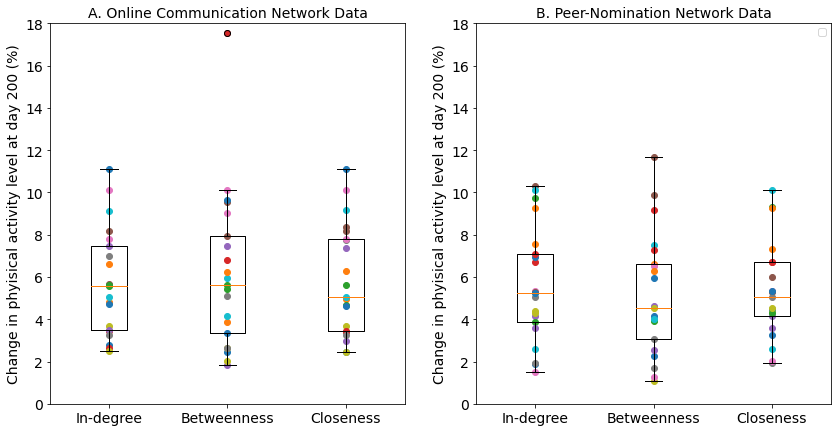

In [105]:
com_clvar = {'In-degree': class_indegree_com.mean(axis=0),
           'Betweenness': class_betweenness_com.mean(axis=0),
           'Closeness': class_closeness_com.mean(axis=0)}

nom_clvar = {'In-degree': class_indegree_nom.mean(axis=0),
           'Betweenness': class_betweenness_nom.mean(axis=0),
           'Closeness': class_closeness_nom.mean(axis=0)}

nom_soc_clvar = {'In-degree': class_indegree_nom_soc.mean(axis=0),
           'Betweenness': class_betweenness_nom_soc.mean(axis=0),
           'Closeness': class_closeness_nom_soc.mean(axis=0)}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))

ax1.set_title('A. Online Communication Network Data', fontsize=14)
ax1.set_ylabel('Change in phyisical activity level at day 200 (%)', fontsize=14)
ax1.tick_params(axis='both', which='both', labelsize=14)
ax1.set_ylim([0, 18])
ax1.plot(com_clvar.values(), 'o')
ax1.boxplot([com_clvar['In-degree'], com_clvar['Betweenness'], com_clvar['Closeness']],
            positions=range(len(com_clvar)),
            labels=['In-degree', 'Betweenness', 'Closeness'])

ax2.set_title('B. Peer-Nomination Network Data', fontsize=14)
ax2.set_ylabel('Change in phyisical activity level at day 200 (%)', fontsize=14)
ax2.tick_params(axis='both', which='both', labelsize=14)
ax2.set_ylim([0, 18])
ax2.plot(nom_soc_clvar.values(), 'o')
ax2.boxplot([nom_soc_clvar['In-degree'], nom_soc_clvar['Betweenness'], nom_soc_clvar['Closeness']],
            positions=range(len(nom_soc_clvar)),
            labels=['In-degree', 'Betweenness', 'Closeness'])

plt.legend()
plt.show()

In [106]:
fig.savefig('../output/plots/fig_classvariation_revised.png', bbox_inches='tight', format='png', dpi=1000)

In [20]:
com_clstd = {'In-degree': class_indegree_com.mean(axis=0),
             'In-degree_min': (class_indegree_com.mean(axis=0) - 1.96 * class_indegree_com.std(axis=0) /np.sqrt(100)),
             'In-degree_max': (class_indegree_com.mean(axis=0) + 1.96 * class_indegree_com.std(axis=0) /np.sqrt(100)),
             'Betweenness': class_betweenness_com.mean(axis=0),
             'Betweenness_min': (class_betweenness_com.mean(axis=0) - 1.96 * class_betweenness_com.std(axis=0) /np.sqrt(100)),
             'Betweenness_max': (class_betweenness_com.mean(axis=0) + 1.96 * class_betweenness_com.std(axis=0) /np.sqrt(100)),
             'Closeness': class_closeness_com.mean(axis=0),
             'Closeness_min': (class_closeness_com.mean(axis=0) - 1.96 * class_closeness_com.std(axis=0) /np.sqrt(100)),
             'Closeness_max': (class_closeness_com.mean(axis=0) + 1.96 * class_closeness_com.std(axis=0) /np.sqrt(100))}

df_com_clstd = pd.DataFrame(com_clstd)
df_com_clstd

,In-degree,In-degree_min,In-degree_max,Betweenness,Betweenness_min,Betweenness_max,Closeness,Closeness_min,Closeness_max
0,2.774526,2.503147,3.045906,2.451227,2.212557,2.689896,2.451227,2.212557,2.689896
1,4.805459,4.429669,5.181248,3.863602,3.482412,4.244791,4.937015,4.572800,5.301229
2,5.561670,5.130844,5.992496,5.411341,5.080851,5.741830,4.677007,4.335929,5.018085
3,2.634073,2.339823,2.928323,17.531690,9.612275,25.451105,3.419124,2.619886,4.218362
4,7.486065,7.113744,7.858386,7.486065,7.113744,7.858386,7.357632,6.874779,7.840485
5,5.652851,5.157996,6.147705,9.566240,7.081046,12.051435,8.381355,6.636308,10.126402
6,10.123702,5.063882,15.183523,10.123702,5.063882,15.183523,10.123702,5.063882,15.183523
7,6.998909,6.481424,7.516395,5.086623,4.849655,5.323592,7.740407,7.300326,8.180488
8,3.691027,3.429854,3.952201,2.653103,2.338099,2.968107,3.691027,3.429854,3.952201
9,9.141193,8.653420,9.628966,5.958861,5.604493,6.313229,9.170107,8.643348,9.696865


In [56]:
df_nom_soc_clvar = pd.DataFrame(nom_soc_clvar)
df_nom_soc_clvar

,In-degree,Betweenness,Closeness
0,1.886963,2.264371,3.256986
1,7.542297,6.591481,7.306201
2,9.717393,3.935486,9.323443
3,6.685524,9.177192,6.685524
4,4.131275,4.646146,4.131275
5,10.324048,11.655407,5.990430
6,5.314878,6.504246,5.314878
7,1.924330,1.702962,1.924330
8,4.409698,1.064172,4.409698
9,10.112124,7.491444,10.112124


In [57]:
print(df_nom_soc_clvar.median(), df_nom_soc_clvar.min(), df_nom_soc_clvar.max())

In-degree      5.228374
Betweenness    4.512316
Closeness      5.068645
dtype: float64 In-degree      1.518411
Betweenness    1.064172
Closeness      1.924330
dtype: float64 In-degree      10.324048
Betweenness    11.655407
Closeness      10.112124
dtype: float64


In [58]:
df_com_clvar = pd.DataFrame(com_clvar)
df_com_clvar

,In-degree,Betweenness,Closeness
0,2.774526,2.451227,2.451227
1,4.805459,3.863602,4.937015
2,5.561670,5.411341,4.677007
3,2.634073,17.531690,3.419124
4,7.486065,7.486065,7.357632
5,5.652851,9.566240,8.381355
6,10.123702,10.123702,10.123702
7,6.998909,5.086623,7.740407
8,3.691027,2.653103,3.691027
9,9.141193,5.958861,9.170107


In [59]:
print(df_com_clvar.median(), df_com_clvar.std())

In-degree      5.561670
Betweenness    5.632734
Closeness      5.040508
dtype: float64 In-degree      2.485872
Betweenness    1.816891
Closeness      2.451227
dtype: float64 In-degree      11.112831
Betweenness    17.531690
Closeness      11.112831
dtype: float64


### 3.1. boxplot variation within classses

Text(0.5, 0, 'Class ID')

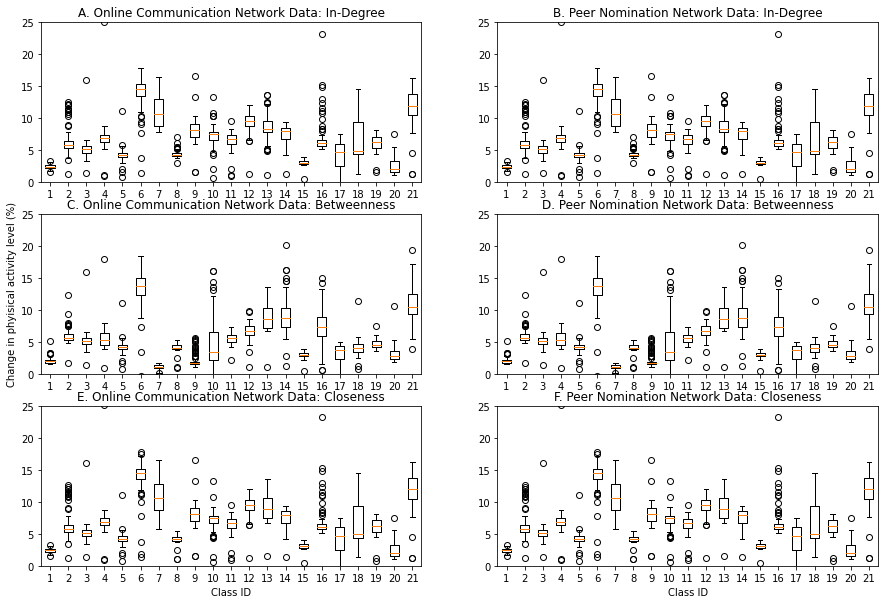

In [70]:
fig, axs = plt.subplots(3, 2, figsize=(15,10))

axs[0,0].set_title('A. Online Communication Network Data: In-Degree')
axs[0,0].set_ylim([0, 25])
axs[0,0].boxplot(class_indegree_com)

axs[0,1].set_title('B. Peer Nomination Network Data: In-Degree')
axs[0,1].set_ylim([0, 25])
axs[0,1].boxplot(class_indegree_nom)

axs[1,0].set_title('C. Online Communication Network Data: Betweenness')
axs[1,0].set_ylabel('Change in phyisical activity level (%)')
axs[1,0].set_ylim([0, 25])
axs[1,0].boxplot(class_betweenness_com)

axs[1,1].set_title('D. Peer Nomination Network Data: Betweenness')
axs[1,1].set_ylim([0, 25])
axs[1,1].boxplot(class_betweenness_nom)

axs[2,0].set_title('E. Online Communication Network Data: Closeness')
axs[2,0].set_ylim([0, 25])
axs[2,0].boxplot(class_closeness_com)
axs[2,0].set_xlabel('Class ID')

axs[2,1].set_title('F. Peer Nomination Network Data: Closeness')
axs[2,1].set_ylim([0, 25])
axs[2,1].boxplot(class_closeness_nom)
axs[2,1].set_xlabel('Class ID')

In [ ]:
fig.savefig('../output/plots/fig_classvariation_detailed_revised.eps', bbox_inches='tight', format='eps', dpi=1000)

### Check for outliers

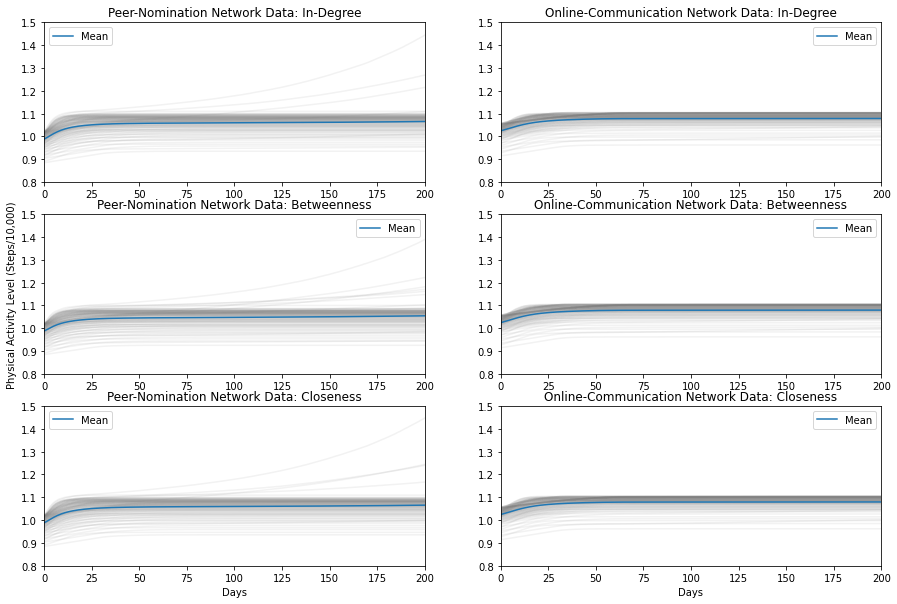

In [31]:
fig, axs = plt.subplots(3, 2, figsize=(15,10))

axs[0,0].set_title('Peer-Nomination Network Data: In-Degree')
axs[0,0].set_xlim([0,200])
axs[0,0].set_ylim([0.8,1.5])
axs[0,0].plot(out_indegree_nom, color='grey', alpha=0.1)
axs[0,0].plot(out_indegree_nom.mean(axis=1), label="Mean")
axs[0,0].legend()

axs[0,1].set_title('Online-Communication Network Data: In-Degree')
axs[0,1].set_xlim([0,200])
axs[0,1].set_ylim([0.8,1.5])
axs[0,1].plot(out_indegree_com, color='grey', alpha=0.1)
axs[0,1].plot(out_indegree_com.mean(axis=1), label="Mean")
axs[0,1].legend()

axs[1,0].set_title('Peer-Nomination Network Data: Betweenness')
axs[1,0].set_xlim([0,200])
axs[1,0].set_ylim([0.8,1.5])
axs[1,0].set_ylabel('Physical Activity Level (Steps/10,000)')
axs[1,0].plot(out_betweenness_nom, color='grey', alpha=0.1)
axs[1,0].plot(out_betweenness_nom.mean(axis=1), label="Mean")
axs[1,0].legend()

axs[1,1].set_title('Online-Communication Network Data: Betweenness')
axs[1,1].set_xlim([0,200])
axs[1,1].set_ylim([0.8,1.5])
axs[1,1].plot(out_betweenness_com, color='grey', alpha=0.1)
axs[1,1].plot(out_betweenness_com.mean(axis=1), label="Mean")
axs[1,1].legend()

axs[2,0].set_title('Peer-Nomination Network Data: Closeness')
axs[2,0].set_xlim([0,200])
axs[2,0].set_ylim([0.8,1.5])
axs[2,0].set_xlabel('Days')
axs[2,0].plot(out_closeness_nom, color='grey', alpha=0.1)
axs[2,0].plot(out_closeness_nom.mean(axis=1), label="Mean")
axs[2,0].legend()

axs[2,1].set_title('Online-Communication Network Data: Closeness')
axs[2,1].set_xlim([0,200])
axs[2,1].set_ylim([0.8,1.5])
axs[2,1].set_xlabel('Days')
axs[2,1].plot(out_closeness_com, color='grey', alpha=0.1)
axs[2,1].plot(out_closeness_com.mean(axis=1), label="Mean")
axs[2,1].legend()

In [38]:
# remove outliers #

out_indegree_nom[999:1000] = out_indegree_nom[999:1000].where(out_indegree_nom[999:1000] < 1.2)
out_indegree_nom2 = out_indegree_nom.dropna(axis=1)

out_indegree_com[999:1000] = out_indegree_com[999:1000].where(out_indegree_com[999:1000] < 1.2)
out_indegree_com2 = out_indegree_com.dropna(axis=1)

out_betweenness_nom[999:1000] = out_betweenness_nom[999:1000].where(out_betweenness_nom[999:1000] < 1.2)
out_betweenness_nom2 = out_betweenness_nom.dropna(axis=1)

out_betweenness_com[999:1000] = out_betweenness_com[999:1000].where(out_betweenness_com[999:1000] < 1.2)
out_betweenness_com2 = out_betweenness_com.dropna(axis=1)

out_closeness_nom[999:1000] = out_closeness_nom[999:1000].where(out_closeness_nom[999:1000] < 1.2)
out_closeness_nom2 = out_closeness_nom.dropna(axis=1)

out_closeness_com[999:1000] = out_closeness_com[999:1000].where(out_closeness_com[999:1000] < 1.2)
out_closeness_com2 = out_closeness_com.dropna(axis=1)


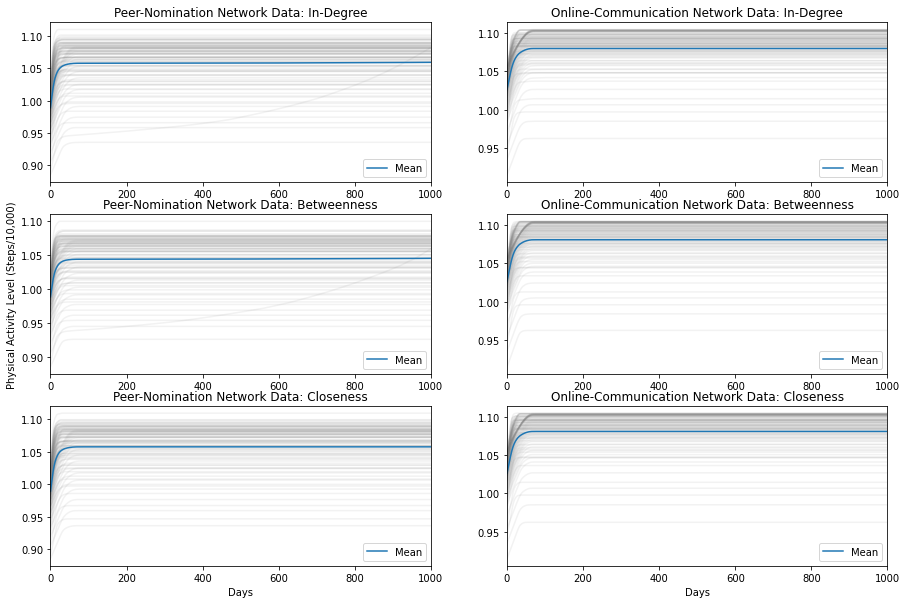

In [89]:
fig, axs = plt.subplots(3, 2, figsize=(15,10))

axs[0,0].set_title('Peer-Nomination Network Data: In-Degree')
axs[0,0].set_xlim([0,1000])
axs[0,0].plot(out_indegree_nom2, color='grey', alpha=0.1)
axs[0,0].plot(out_indegree_nom2.mean(axis=1), label="Mean")
axs[0,0].legend()

axs[0,1].set_title('Online-Communication Network Data: In-Degree')
axs[0,1].set_xlim([0,1000])
axs[0,1].plot(out_indegree_com2, color='grey', alpha=0.1)
axs[0,1].plot(out_indegree_com2.mean(axis=1), label="Mean")
axs[0,1].legend()

axs[1,0].set_title('Peer-Nomination Network Data: Betweenness')
axs[1,0].set_xlim([0,1000])
axs[1,0].set_ylabel('Physical Activity Level (Steps/10,000)')
axs[1,0].plot(out_betweenness_nom2, color='grey', alpha=0.1)
axs[1,0].plot(out_betweenness_nom2.mean(axis=1), label="Mean")
axs[1,0].legend()

axs[1,1].set_title('Online-Communication Network Data: Betweenness')
axs[1,1].set_xlim([0,1000])
axs[1,1].plot(out_betweenness_com2, color='grey', alpha=0.1)
axs[1,1].plot(out_betweenness_com2.mean(axis=1), label="Mean")
axs[1,1].legend()

axs[2,0].set_title('Peer-Nomination Network Data: Closeness')
axs[2,0].set_xlim([0,1000])
axs[2,0].set_xlabel('Days')
axs[2,0].plot(out_closeness_nom2, color='grey', alpha=0.1)
axs[2,0].plot(out_closeness_nom2.mean(axis=1), label="Mean")
axs[2,0].legend()

axs[2,1].set_title('Online-Communication Network Data: Closeness')
axs[2,1].set_xlim([0,1000])
axs[2,1].set_xlabel('Days')
axs[2,1].plot(out_closeness_com2, color='grey', alpha=0.1)
axs[2,1].plot(out_closeness_com2.mean(axis=1), label="Mean")
axs[2,1].legend()